# Final Model (Classwise/Y Scaling/Vt Feature/Drain Feature/MoE) with XGBoost

## Feautre engineering

- We will estimate Vt, Drain equation, saturation points in order to use them as feautres

In [1]:
import torch
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load


In [2]:
vt_model = xgboost.XGBRegressor()
vt_model.load_model('../checkpoint/vt_xgboost_model.model')

In [3]:
full_df = pd.read_csv('../data_full/full_dataset.csv')
full_df.head()

,Vds,Vgs,Ids,W,L,T
0,0.1,-20.0,9.424700e-15,10,5,0
1,0.1,-19.8,9.424700e-15,10,5,0
2,0.1,-19.6,9.424700e-15,10,5,0
3,0.1,-19.4,9.424700e-15,10,5,0
4,0.1,-19.2,9.424700e-15,10,5,0


In [4]:
full_df['Vt'] = full_df.apply(lambda row : vt_model.predict([row[['W','L', 'T','Vds']].to_numpy()])[0], axis=1)
full_df.head()

,Vds,Vgs,Ids,W,L,T,Vt
0,0.1,-20.0,9.424700e-15,10,5,0,0.999991
1,0.1,-19.8,9.424700e-15,10,5,0,0.999991
2,0.1,-19.6,9.424700e-15,10,5,0,0.999991
3,0.1,-19.4,9.424700e-15,10,5,0,0.999991
4,0.1,-19.2,9.424700e-15,10,5,0,0.999991


In [5]:
def calculate_drain_equation(width, length, vgs, vds, vt):
    right_term = (vgs-vt)*vds - 1/2*(vds**2)
    return (width/length)*right_term

In [6]:
full_df['Drain'] = full_df.apply(lambda row : calculate_drain_equation(row['W'], row['L'], row['Vgs'], row['Vds'], row['Vt']), axis=1)
print(full_df)

        Vds   Vgs           Ids     W   L   T        Vt         Drain
0       0.1 -20.0  9.424700e-15    10   5   0  0.999991     -4.209998
1       0.1 -19.8  9.424700e-15    10   5   0  0.999991     -4.169998
2       0.1 -19.6  9.424700e-15    10   5   0  0.999991     -4.129998
3       0.1 -19.4  9.424700e-15    10   5   0  0.999991     -4.089998
4       0.1 -19.2  9.424700e-15    10   5   0  0.999991     -4.049998
...     ...   ...           ...   ...  ..  ..       ...           ...
86827  30.0  19.2  1.238200e-02  1000  12  80  0.599660   9000.849754
86828  30.0  19.4  1.263100e-02  1000  12  80  0.599660   9500.849754
86829  30.0  19.6  1.288200e-02  1000  12  80  0.599660  10000.849754
86830  30.0  19.8  1.313300e-02  1000  12  80  0.599660  10500.849754
86831  30.0  20.0  1.338700e-02  1000  12  80  0.599660  11000.849754

[86832 rows x 8 columns]


In [7]:
WIDTHS = [10, 20, 35, 50, 100, 1000]
LENGTHS = [5, 8, 10, 12]
TEMPS = [0, 25, 80]
VGS = np.unique(full_df.Vgs)

In [8]:
full_df['saturation_points'] = np.nan

In [9]:
full_df_copy = full_df.copy()

In [33]:
full_df = full_df_copy.copy()

In [10]:
for width in WIDTHS:
    for length in LENGTHS:
        for temperature in TEMPS:
            query_1 = 'W=='+str(width)+' and ' + 'L=='+str(length)+' and '+'T=='+str(temperature)
            full_df_part = full_df.query(query_1)
            VGSes = np.unique(full_df_part.Vgs)
            
            saturation_point_dict = {}
            for vgs in VGSes:
                query_2 = 'Vgs=='+str(vgs)
                full_df_part_vgs = full_df_part.query(query_2)
                p1 = full_df_part_vgs.query('Vds==0.1')[['Ids','Vds']].values
                p2 = full_df_part_vgs.query('Vds==30')[['Ids','Vds']].values
                
                max_dist=-99
                VDSes = full_df_part_vgs['Vds'].unique()

                
                for vds in VDSes:
                    p3 = full_df_part_vgs.query('Vds=='+str(vds))[['Ids','Vds']].values
                    current_dist = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1) 
                    ##refer to https://stackoverflow.com/questions/39840030/distance-between-point-and-a-line-from-two-points

                    if current_dist > max_dist:
                        max_dist = current_dist
                        elbow_point = vds
                        
                #saturation_point[vgs] = elbow_point
                
                full_df.loc[(full_df['W']==width) & (full_df['L']==length) & (full_df['T']==temperature) &
                           (full_df['Vgs']==vgs), 'saturation_points'] = elbow_point
                
                
            

In [11]:
full_df['greater_than_saturation_points'] = (full_df.Vds > full_df.saturation_points).astype(int)

In [14]:
full_df.head()

,Vds,Vgs,Ids,W,L,T,Vt,Drain,saturation_points,greater_than_saturation_points
0,0.1,-20.0,9.424700e-15,10,5,0,0.999991,-4.209998,1.0,0
1,0.1,-19.8,9.424700e-15,10,5,0,0.999991,-4.169998,1.0,0
2,0.1,-19.6,9.424700e-15,10,5,0,0.999991,-4.129998,1.0,0
3,0.1,-19.4,9.424700e-15,10,5,0,0.999991,-4.089998,1.0,0
4,0.1,-19.2,9.424700e-15,10,5,0,0.999991,-4.049998,1.0,0


### Check whether we got correct saturation points

In [15]:
test_df = full_df.query('W==20 and L==8 and T==25')

In [16]:
test_df

,Vds,Vgs,Ids,W,L,T,Vt,Drain,saturation_points,greater_than_saturation_points
19296,0.1,-20.0,1.502000e-13,20,8,25,0.999844,-5.262461,1.0,0
19297,0.1,-19.8,1.502000e-13,20,8,25,0.999844,-5.212461,1.0,0
19298,0.1,-19.6,1.502000e-13,20,8,25,0.999844,-5.162461,1.0,0
19299,0.1,-19.4,1.502000e-13,20,8,25,0.999844,-5.112461,1.0,0
19300,0.1,-19.2,1.502000e-13,20,8,25,0.999844,-5.062461,1.0,0
...,...,...,...,...,...,...,...,...,...,...
20497,30.0,19.2,3.634100e-04,20,8,25,0.400083,284.993788,10.0,1
20498,30.0,19.4,3.702800e-04,20,8,25,0.400083,299.993788,10.0,1
20499,30.0,19.6,3.771700e-04,20,8,25,0.400083,314.993788,10.0,1
20500,30.0,19.8,3.840900e-04,20,8,25,0.400083,329.993788,10.0,1


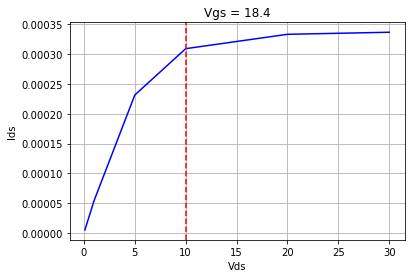

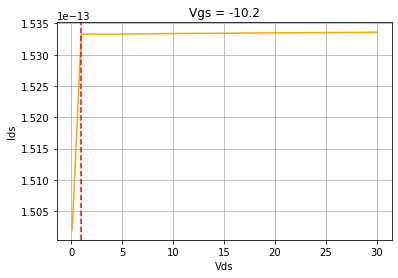

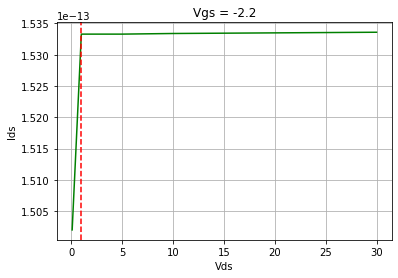

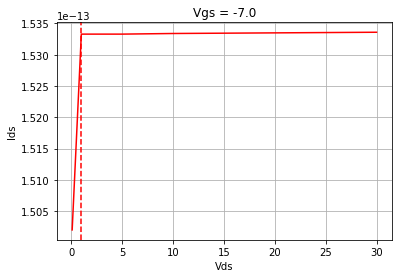

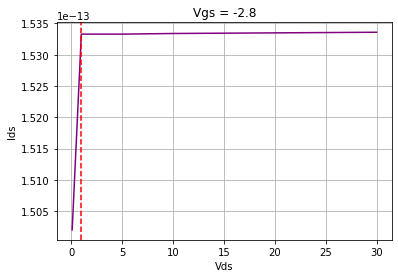

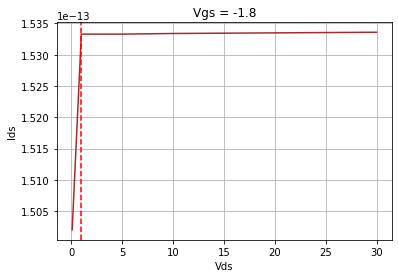

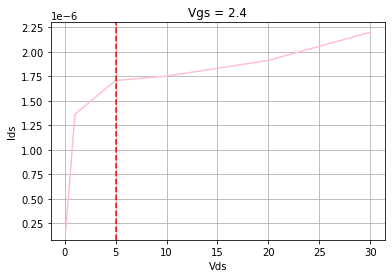

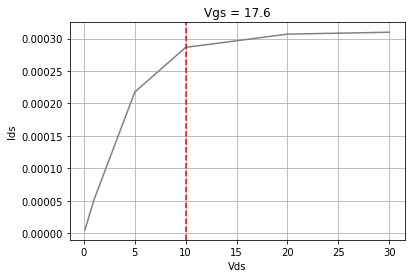

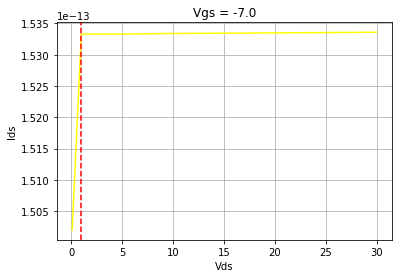

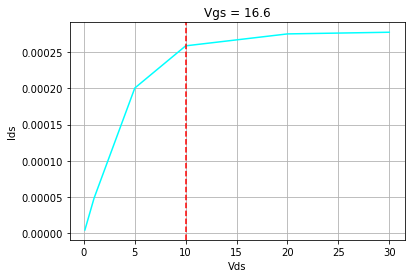

In [17]:
color_ls = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'cyan']

for i in range(10):
    testing_vgs = np.random.choice(VGS)
    plt.plot(test_df.query('Vgs=='+str(testing_vgs))['Vds'], test_df.query('Vgs=='+str(testing_vgs))['Ids'], color=color_ls[i])
    plt.axvline(np.unique(test_df.query('Vgs=='+str(testing_vgs))['saturation_points']), color='red', linestyle='--') ## Check whether we got correct saturation point.
    plt.xlabel('Vds')
    plt.ylabel('Ids')
    plt.title('Vgs = '+ str(testing_vgs))
    plt.grid()
    plt.show()

# Modeling
 - We will use three models according to given inputs.
     - When input has Vgs < 0, we will use model1.
     - When input has Vgs >= 0 and Vds > saturation point, we will use model2.
     - When input has Vgs >= 0 and Vds <= saturation point, we will use model3.
     - Model1 and model3 uses a dummy variable which indicates whehter Vds is greater than saturation point or not.

In [12]:
class_0_df = full_df.query('Vgs<0')
class_1_df = full_df.query('Vgs>=0')

In [13]:
def custom_objective(y, y_hat, eps=1e-8):
    # grad = 2*np.log(abs(y_hat)/abs(y)-abs(y)+eps) + 2*((y_hat-y)/(y+eps))
    grad = 2*((y_hat-y)/(y+eps))
    hess = np.full(y_hat.shape, 2)
    # hess = np.full(y_hat.shape, 4)
    return grad, hess

## Model 1

In [14]:
# full_df = pd.read_csv('../data_full/full_dataset.csv')
class_0_y = class_0_df[['Ids']].to_numpy()
# scaler_0_y = StandardScaler().fit(class_0_y)
# class_0_y = scaler_0_y.transform(class_0_y)
class_0_y = np.log(class_0_y)
class_0_X = class_0_df[['W','L','T','Vgs','Vds', 'Vt', 'Drain', 'greater_than_saturation_points']].to_numpy()

class_0_X_train, class_0_X_test, class_0_y_train, class_0_y_test = train_test_split(class_0_X, class_0_y, test_size=0.1, random_state=22)

scaler_0_X = StandardScaler().fit(class_0_X_train)
class_0_X_train = scaler_0_X.transform(class_0_X_train)
class_0_X_test = scaler_0_X.transform(class_0_X_test)
dump(scaler_0_X, '../checkpoint/scaled_classified_vt_drain_xbgoost_class_0_std_scaler_train_MOE.bin', compress=True)
class_0_xgb_model = xgboost.XGBRegressor(objective='reg:squarederror')
parameters = {'booster' :['gbtree'],
                 'silent':[True],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,2,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50],
                 'objective':['reg:squarederror'],
                 'random_state':[2]}

class_0_xgb_grid = GridSearchCV(class_0_xgb_model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

print(len(class_0_X_train), len(class_0_X_test))
class_0_xgb_grid.fit(class_0_X_train,class_0_y_train)
print(class_0_xgb_grid.best_score_)
print(class_0_xgb_grid.best_params_)

39268 4364
Fitting 2 folds for each of 72 candidates, totalling 144 fits
[21:25:28] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:25:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:25:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed dow

[21:25:28] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:25:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:25:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

[21:25:28] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:25:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:25:29] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

0.998951360446888
{'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bytree': 0.5, 'gamma': 0, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 50, 'nthread': 4, 'objective': 'reg:squarederror', 'random_state': 2, 'silent': True}


In [15]:
# xgb_model = xgboost.XGBRegressor(colsample_bytree=0.7, learning_rate=0.07, max_depth=5, min_child_weight=4, n_estimators=500, nthread=4, objective='reg:linear', silent=1, subsample=0.7)
# xgb_model = xgb_grid.best_estimator_
class_0_xgb_model.fit(class_0_X_train, class_0_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=32,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

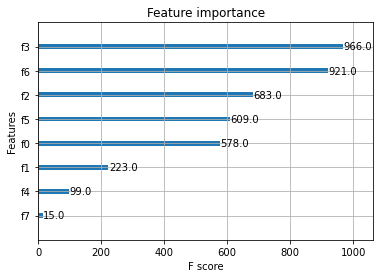

In [16]:
xgboost.plot_importance(class_0_xgb_model)

In [17]:
predictions = class_0_xgb_model.predict(class_0_X_test)
predictions

array([-30.200546, -29.97626 , -25.440708, ..., -29.5279  , -27.79812 ,
       -22.051704], dtype=float32)

In [18]:
class_0_y_test.flatten()

array([-30.1992659 , -29.97815389, -25.44236649, ..., -29.52680866,
       -27.89362041, -22.05185749])

In [19]:
r_sq = class_0_xgb_model.score(class_0_X_train, class_0_y_train)
print(r_sq)
print(explained_variance_score(predictions,class_0_y_test))

0.9999262625914245
0.9989729593295584


In [21]:
def NRMSELoss(y_hat, y, eps=1e-8):
    log_abs_y_hat = torch.log(torch.abs(y_hat)+eps)
    log_abs_y = torch.log(torch.abs(y)+eps)
    log_abs_delta = log_abs_y_hat - log_abs_y
    delta = y_hat - y
    len_delta = y_hat.size(dim=0)
    return torch.sqrt((1/len_delta)*torch.sum((log_abs_delta/(log_abs_y+eps))**2)) + torch.sqrt((1/len_delta)*torch.sum((delta/(y+eps))**2))

In [94]:
predictions = class_0_xgb_model.predict(class_0_X_test)
# predictions = scaler_0_y.inverse_transform([predictions])
predictions = torch.tensor(np.exp(predictions))
print(predictions)
actuals = np.exp(class_0_y_test)
# actuals = scaler_0_y.inverse_transform(actuals)
actuals = torch.tensor(actuals.flatten())
print(actuals)
class0_nrmse = NRMSELoss(predictions, actuals)
print(class0_nrmse)

tensor([7.6572e-14, 9.5824e-14, 8.9380e-12,  ..., 1.5004e-13, 8.4612e-13,
        2.6489e-10])
tensor([7.6670e-14, 9.5643e-14, 8.9232e-12,  ..., 1.5020e-13, 7.6905e-13,
        2.6485e-10], dtype=torch.float64)
tensor(0.0166, dtype=torch.float64)


In [105]:
class_0_xgb_model.save_model('../checkpoint/scaled_classified_vt_saturation_xgboost_class_0_MOE.model')

- We need to train all data including test data after validation.

In [23]:
class_0_xgb_submission = xgboost.XGBRegressor(objective='reg:squarederror')
class_0_X_all = scaler_0_X.transform(class_0_X)
class_0_xgb_submission.fit(class_0_X_all, class_0_y) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=32,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [24]:
class_0_xgb_submission.save_model('../checkpoint/scaled_classified_vt_saturation_xgboost_class_0_submission_MOE.model')

[21:25:36] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:25:36] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:25:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

## Model 2

In [48]:
# full_df = pd.read_csv('../data_full/full_dataset.csv')
class_1_y = class_1_df[['Ids']].to_numpy()
class_1_y = np.log(class_1_y)
class_1_X = class_1_df[['W','L','T','Vgs','Vds', 'Vt', 'Drain']].to_numpy()


class_1_X_train, class_1_X_test, class_1_y_train, class_1_y_test = train_test_split(class_1_X, class_1_y, test_size=0.1, random_state=22)

scaler_1_X = StandardScaler().fit(class_1_X_train)
class_1_X_train = scaler_1_X.transform(class_1_X_train)
class_1_X_test = scaler_1_X.transform(class_1_X_test)
class_1_X_test_no_saturation = class_1_X_test.copy() ##for later use
dump(scaler_1_X, '../checkpoint/scaled_classified_vt_drain_xbgoost_class_1_std_scaler_train_MOE.bin', compress=True)

class_1_xgb_model = xgboost.XGBRegressor(objective='reg:squarederror')
parameters = {'booster' :['gbtree'],
                 'silent':[True],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,2,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50],
                 'objective':['reg:squarederror'],
                 'random_state':[2]}

class_1_xgb_grid = GridSearchCV(class_1_xgb_model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

print(len(class_1_X_train), len(class_1_X_test))
class_1_xgb_grid.fit(class_1_X_train,class_1_y_train)
print(class_1_xgb_grid.best_score_)
print(class_1_xgb_grid.best_params_)

38880 4320
Fitting 2 folds for each of 72 candidates, totalling 144 fits
[21:56:30] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:30] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:31] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed dow

[21:56:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:34] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

[21:56:38] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:48] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

[21:56:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

0.9986143492421318
{'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 50, 'nthread': 4, 'objective': 'reg:squarederror', 'random_state': 2, 'silent': True}


In [49]:
class_1_xgb_model.fit(class_1_X_train, class_1_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=32,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

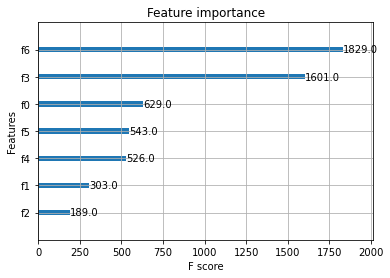

In [27]:
xgboost.plot_importance(class_1_xgb_model)

In [28]:
predictions = class_1_xgb_model.predict(class_1_X_test)
predictions

array([-16.690931 ,  -7.164318 , -13.319407 , ...,  -6.5139766,
        -8.848608 , -11.605148 ], dtype=float32)

In [29]:
class_1_y_test.flatten()

array([-16.58017873,  -7.09244764, -13.31698021, ...,  -6.47909461,
        -8.79459495, -11.69790656])

In [30]:
r_sq = class_1_xgb_model.score(class_1_X_train, class_1_y_train)
print(r_sq)
print(explained_variance_score(predictions,class_1_y_test))

0.9996508044091971
0.9995007937900089


tensor(0.0703, dtype=torch.float64)


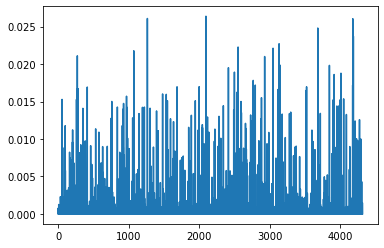

In [31]:
predictions = torch.tensor(np.exp(class_1_xgb_model.predict(class_1_X_test)))
actuals = torch.tensor(np.exp(class_1_y_test.flatten()))
nrmse = NRMSELoss(predictions, actuals)
print(nrmse)

plt.plot(predictions.numpy())

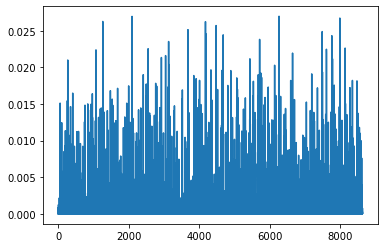

In [80]:
plt.plot(actuals.numpy())

In [32]:
class_1_xgb_model.save_model('../checkpoint/scaled_classified_vt_xgboost_class_1_MOE.model')

- We need to train all data including test data after validation.

In [33]:
class_1_xgb_submission = xgboost.XGBRegressor(objective='reg:squarederror')
class_1_X_all = scaler_1_X.transform(class_1_X)
class_1_xgb_submission.fit(class_1_X_all, class_1_y) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=32,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [35]:
class_1_xgb_submission.save_model('../checkpoint/scaled_classified_vt_xgboost_class_1_submission_MOE.model')

[21:31:02] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:31:02] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:31:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

## Model 3

In [50]:
# full_df = pd.read_csv('../data_full/full_dataset.csv')
class_1_y = class_1_df[['Ids']].to_numpy()
class_1_y = np.log(class_1_y)
class_1_X = class_1_df[['W','L','T','Vgs','Vds', 'Vt', 'Drain','greater_than_saturation_points']].to_numpy()


class_1_X_train, class_1_X_test, class_1_y_train, class_1_y_test = train_test_split(class_1_X, class_1_y, test_size=0.1, random_state=22)

scaler_1_X = StandardScaler().fit(class_1_X_train)
class_1_X_train = scaler_1_X.transform(class_1_X_train)
class_1_X_test = scaler_1_X.transform(class_1_X_test)
class_1_X_test_saturation = class_1_X_test.copy() ##for later use
dump(scaler_1_X, '../checkpoint/scaled_classified_vt_drain_xbgoost_class_1_std_scaler_train_saturation_MOE.bin', compress=True)

class_1_xgb_model_saturation = xgboost.XGBRegressor(objective='reg:squarederror')
parameters = {'booster' :['gbtree'],
                 'silent':[True],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,2,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50],
                 'objective':['reg:squarederror'],
                 'random_state':[2]}

class_1_xgb_grid = GridSearchCV(class_1_xgb_model_saturation,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

print(len(class_1_X_train), len(class_1_X_test))
class_1_xgb_grid.fit(class_1_X_train,class_1_y_train)
print(class_1_xgb_grid.best_score_)
print(class_1_xgb_grid.best_params_)

38880 4320
Fitting 2 folds for each of 72 candidates, totalling 144 fits
[21:56:52] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:53] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:53] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed dow

[21:56:55] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:55] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:55] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

[21:56:56] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:56] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:56] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

[21:57:10] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.9991726508721787
{'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 50, 'nthread': 4, 'objective': 'reg:squarederror', 'random_state': 2, 'silent': True}


In [51]:
class_1_xgb_model_saturation.fit(class_1_X_train, class_1_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=32,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

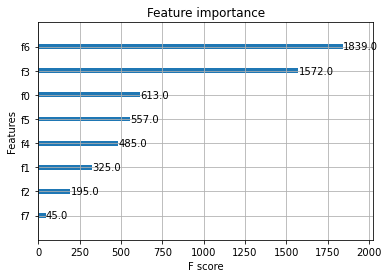

In [38]:
xgboost.plot_importance(class_1_xgb_model_saturation)

In [39]:
predictions = class_1_xgb_model_saturation.predict(class_1_X_test)
predictions

array([-16.612503 ,  -7.156152 , -13.366897 , ...,  -6.4897327,
        -8.829727 , -11.643626 ], dtype=float32)

In [40]:
r_sq = class_1_xgb_model_saturation.score(class_1_X_train, class_1_y_train)
print(r_sq)
print(explained_variance_score(predictions,class_1_y_test))

0.9996418451833617
0.999477955446152


tensor(0.0711, dtype=torch.float64)


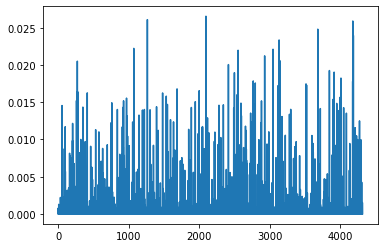

In [41]:
predictions = torch.tensor(np.exp(class_1_xgb_model_saturation.predict(class_1_X_test)))
actuals = torch.tensor(np.exp(class_1_y_test.flatten()))
nrmse = NRMSELoss(predictions, actuals)
print(nrmse)

plt.plot(predictions.numpy())

In [42]:
class_1_xgb_model_saturation.save_model('../checkpoint/scaled_classified_vt_xgboost_class_1_saturation_MOE.model')

- We need to train all data including test data after validation.

In [43]:
class_1_xgb_saturation_submission = xgboost.XGBRegressor(objective='reg:squarederror')
class_1_X_all = scaler_1_X.transform(class_1_X)
class_1_xgb_saturation_submission.fit(class_1_X_all, class_1_y) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=32,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [44]:
class_1_xgb_saturation_submission.save_model('../checkpoint/scaled_classified_vt_xgboost_class_1_saturation_submission_MOE.model')

# Evaluation
 - We need to gather test results of all three models and calculate NRMSE.

In [75]:
class_1_X_test_saturated_Vds = class_1_X_test_no_saturation[class_1_X_test_saturation[:,7] > 0] # Model2 fatures
class_1_X_test_not_saturated_Vds = class_1_X_test[class_1_X_test_saturation[:,7] <= 0] # Model3 features

class_1_y_test_saturated_Vds = class_1_y_test[class_1_X_test_saturation[:,7] > 0] # Model2 targets
class_1_y_test_not_saturated_Vds = class_1_y_test[class_1_X_test_saturation[:,7] <= 0] # Model3 targets

In [79]:
predictions = torch.tensor(np.exp(class_1_xgb_model.predict(class_1_X_test_saturated_Vds)))
actuals = torch.tensor(np.exp(class_1_y_test_saturated_Vds.flatten()))
nrmse = NRMSELoss(predictions, actuals)
print(nrmse)


tensor(0.0791, dtype=torch.float64)


In [78]:
predictions = torch.tensor(np.exp(class_1_xgb_model_saturation.predict(class_1_X_test_not_saturated_Vds)))
actuals = torch.tensor(np.exp(class_1_y_test_not_saturated_Vds.flatten()))
nrmse = NRMSELoss(predictions, actuals)
print(nrmse)

tensor(0.0624, dtype=torch.float64)


In [85]:
def SELoss(y_hat, y, eps=1e-8):
    log_abs_y_hat = torch.log(torch.abs(y_hat)+eps)
    log_abs_y = torch.log(torch.abs(y)+eps)
    log_abs_delta = log_abs_y_hat - log_abs_y
    delta = y_hat - y
    len_delta = y_hat.size(dim=0)
    
    sum_part1 = torch.sum((log_abs_delta/(log_abs_y+eps))**2)
    sum_part2 = torch.sum((delta/(y+eps))**2)
    return sum_part1, sum_part2

In [86]:
predictions = torch.tensor(np.exp(class_1_xgb_model.predict(class_1_X_test_saturated_Vds)))
actuals = torch.tensor(np.exp(class_1_y_test_saturated_Vds.flatten()))
not_saturated_sum1, not_saturated_sum2 = SELoss(predictions, actuals)

In [88]:
predictions = torch.tensor(np.exp(class_1_xgb_model_saturation.predict(class_1_X_test_not_saturated_Vds)))
actuals = torch.tensor(np.exp(class_1_y_test_not_saturated_Vds.flatten()))
saturated_sum1, saturated_sum2 = SELoss(predictions, actuals)

In [89]:
def gather_NRMSELoss(sum_part1_1, sum_part1_2, sum_part2_1, sum_part2_2, data_num):
    sum_part1_total = sum_part1_1 + sum_part1_2
    sum_part2_total = sum_part2_1 + sum_part2_2
    
    
    return torch.sqrt((1/data_num)*sum_part1_total) + torch.sqrt((1/data_num)*sum_part2_total)
    

In [95]:
class1_nrmse = gather_NRMSELoss(not_saturated_sum1,saturated_sum1, not_saturated_sum2, saturated_sum2, class_1_y_test.shape[0] )
print("NRMSE in class0 region : " , class0_nrmse)
print("NRMSE in class1 region: ", class1_nrmse)

tensor(0.0704, dtype=torch.float64)


In [96]:
total_nrmse = class0_nrmse + class1_nrmse
print(total_nrmse)

tensor(0.0870, dtype=torch.float64)


In [102]:
class1_nrmse = gather_NRMSELoss(not_saturated_sum1,saturated_sum1, not_saturated_sum2, saturated_sum2, class_1_y_test.shape[0] )
print("NRMSE in class0 region : " , round(class0_nrmse.item(),4))
print("NRMSE in class1 region: ", round(class1_nrmse.item(),4))

NRMSE in class0 region :  0.0166
NRMSE in class1 region:  0.0704


---